In [45]:
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
import itertools
import random

from tqdm import tqdm
import pickle
import copy
import gc

import sys
sys.path.insert(1, '../c2c_sim/')
from core.utils import get_truncated_normal, piecewise_fit, fit_params
from core.utils import relat,x
from core.simulate import Simulate, CCI_MD

dp = 'figures/'#'/data2/hratch/cci_dt/figures/'
data_path = 'data/'
import warnings
warnings.filterwarnings("ignore")
version = 1

# Background Noise

## No scaling

In [3]:
scale = 1
background_sim = pd.DataFrame(columns = ['values', 'mean', 'noise'])
for mean in np.arange(0.25, 1.01, 0.25):
    for noise in np.arange(0.1, 1.01, 0.1):
        vals = get_truncated_normal(n = 10**5, sd = noise*mean*scale)
        df = pd.DataFrame(columns = ['values', 'mean', 'noise'])
        df['values'] = vals
        df['mean'] = mean
        df['noise'] = noise
        background_sim = pd.concat([background_sim, df])

In [4]:
summ = background_sim[background_sim['noise'] == 1].groupby('mean').mean()
summ.rename(columns = {'values': 'mu_b'}, inplace = True)
summ['mu_l'] = summ.index
summ.reset_index(inplace = True, drop = True)
summ

,mu_b,noise,mu_l
0,0.199151,1.0,0.25
1,0.360530,1.0,0.50
2,0.432089,1.0,0.75
3,0.461378,1.0,1.00


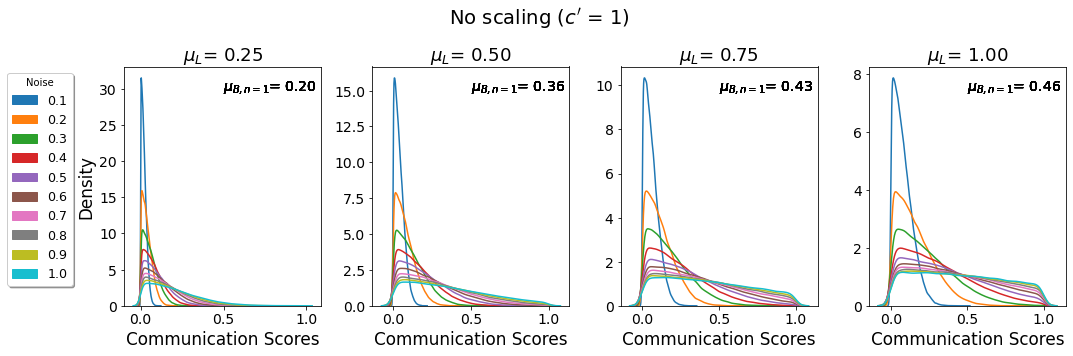

In [13]:
mean_vals = background_sim['mean'].unique().tolist()
noise_vals = background_sim['noise'].unique().tolist()

fig, ax = plt.subplots(nrows = 1, ncols = len(mean_vals), figsize = (15,5))
fontsize = 14
colors = sns.color_palette("tab10")[:len(noise_vals)]

for i in range(len(mean_vals)):
    for j in range(len(noise_vals)):
        viz_df = background_sim[(background_sim['mean'] == mean_vals[i]) & (background_sim['noise'] == noise_vals[j])]
        sns.distplot(a = viz_df['values'], color=colors[j], ax = ax[i], hist = False)
        ax[i].set_title(r'$\mu_L$' + '= {:.2f}'.format(mean_vals[i]), fontsize = 1.3*fontsize)
        ax[i].annotate(r'$\mu_{B, n = 1}$' + '= {:.2f}'.format(summ.loc[i, 'mu_b']), 
                      xycoords = 'axes fraction', xy = (0.5,0.9), fontsize = fontsize)    
        ax[i].set_xlabel('Communication Scores', fontsize = 1.2*fontsize)
        ax[i].tick_params(axis='both', labelsize=fontsize)
        if i > 0:
            ax[i].set_ylabel('')
        else:
            ax[i].set_ylabel('Density', fontsize = 1.2*fontsize)

patches = [mpatches.Patch(color=colors[j], label='{:.1f}'.format(noise_vals[j])) for j in range(len(noise_vals))]
ax[0].legend(handles=patches, title = 'Noise', bbox_to_anchor=(-0.23, 1), fontsize = 0.9*fontsize, 
            fancybox = True, shadow = True)
fig.suptitle("No scaling ($\it{c'}$ = 1)", fontsize = 1.4*fontsize)
fig.subplots_adjust(top=0.8)

fig.align_xlabels(ax[:])
plt.tight_layout()

for ext in ['.pdf', '.png', '.svg']:
    plt.savefig(dp + 'background_noise_means_noscale' + ext, bbox_inches = 'tight')

## Scaling

''

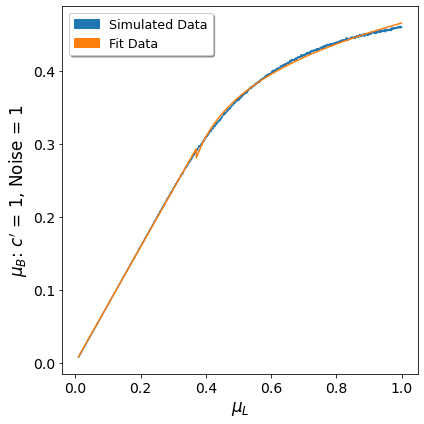

In [14]:
fontsize = 14

relat['fit_mean'] = piecewise_fit(x, *fit_params)
for col in relat.columns:
    relat[col] = relat[col].astype(float)

colors = sns.color_palette("tab10")[:2]
fig,ax =plt.subplots(figsize = (6,6))
sns.lineplot(data = relat, x = 'mean', y = 'noise_mean', ax = ax, color = colors[0])
sns.lineplot(data = relat, x = 'mean', y = 'fit_mean', ax = ax, color = colors[1])
ax.set_ylabel(r'$\mu_B$' + ": $\it{c'}$ = 1, Noise = 1", fontsize = 1.2*fontsize)
ax.set_xlabel(r'$\mu_L$', fontsize = 1.2*fontsize)
ax.tick_params(axis='both', labelsize=fontsize)

patch1 = mpatches.Patch(color=colors[0], label='Simulated Data')
patch2 = mpatches.Patch(color=colors[1], label='Fit Data')
plt.legend(handles=[patch1,patch2], fancybox = True, shadow = True, fontsize = 0.9*fontsize)
plt.tight_layout()
for ext in ['.pdf', '.png', '.svg']:
    plt.savefig(dp + 'curve_fitting_background_noise' + ext, bbox_inches = 'tight')
;

In [15]:
background_sim = pd.DataFrame(columns = ['values', 'mean', 'noise'])
for mean in np.arange(0.25, 1.01, 0.25):
    scale = mean/np.array([piecewise_fit(mean, *fit_params)])[0]
    for noise in np.arange(0.1, 1.01, 0.1):
        vals = get_truncated_normal(n = 10**5, sd = noise*mean)*scale
        df = pd.DataFrame(columns = ['values', 'mean', 'noise'])
        df['values'] = vals
        df['mean'] = mean
        df['noise'] = noise
        background_sim = pd.concat([background_sim, df])

In [16]:
summ = background_sim[background_sim['noise'] == 1].groupby('mean').mean()
summ.rename(columns = {'values': 'mu_B'}, inplace = True)
summ['mu_L'] = summ.index
summ.reset_index(inplace = True, drop = True)
summ

,mu_B,noise,mu_L
0,0.250822,1.0,0.25
1,0.494996,1.0,0.50
2,0.755263,1.0,0.75
3,0.982153,1.0,1.00


''

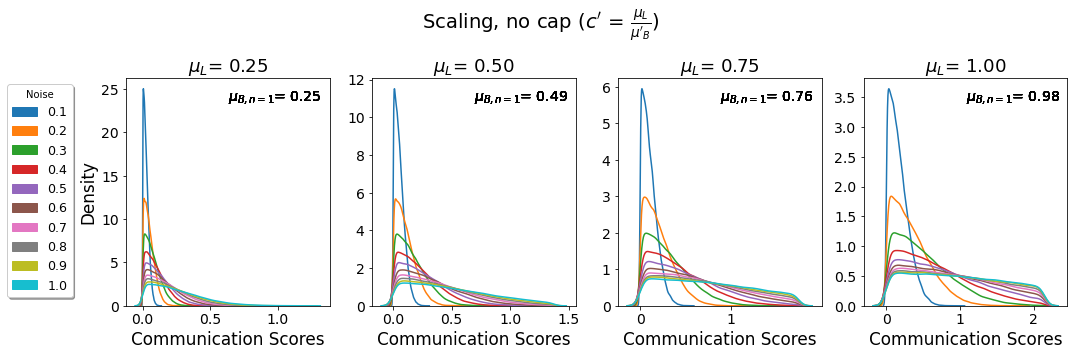

In [18]:
mean_vals = background_sim['mean'].unique().tolist()
noise_vals = background_sim['noise'].unique().tolist()
colors = sns.color_palette("tab10")[:len(noise_vals)]
fig, ax = plt.subplots(nrows = 1, ncols = len(mean_vals), figsize = (15,5))
for i in range(len(mean_vals)):
    for j in range(len(noise_vals)):
        viz_df = background_sim[(background_sim['mean'] == mean_vals[i]) & (background_sim['noise'] == noise_vals[j])]
        sns.distplot(a = viz_df['values'], color=colors[j], ax = ax[i], hist = False)
        ax[i].set_title(r'$\mu_L$' + '= {:.2f}'.format(mean_vals[i]), fontsize = 1.3*fontsize)
        ax[i].annotate(r'$\mu_{B, n = 1}$' + '= {:.2f}'.format(summ.loc[i, 'mu_B']), 
              xycoords = 'axes fraction', xy = (0.5,0.9), fontsize = fontsize)    
        ax[i].set_xlabel('Communication Scores', fontsize = 1.2*fontsize)
        ax[i].tick_params(axis='both', labelsize=fontsize)
        if i > 0:
            ax[i].set_ylabel('')
        else:
            ax[i].set_ylabel('Density', fontsize = 1.2*fontsize)
    

patches = [mpatches.Patch(color=colors[j], label='{:.1f}'.format(noise_vals[j])) for j in range(len(noise_vals))]
ax[0].legend(handles=patches, title = 'Noise', bbox_to_anchor=(-0.23, 1), fancybox = True, shadow = True, 
            fontsize = 0.9*fontsize)
fig.suptitle("Scaling, no cap ($\it{c'}$ = " + r"$\frac{\mu_L}{\mu'_B}$" + ')', fontsize = 1.4*fontsize)
plt.subplots_adjust(top = 0.8)
fig.align_xlabels(ax[:])
plt.tight_layout()

for ext in ['.pdf', '.png', '.svg']:
    plt.savefig(dp + 'background_noise_means_scale' + ext, bbox_inches = 'tight')
;

In [19]:
background_sim = pd.DataFrame(columns = ['values', 'mean', 'noise'])
for mean in np.arange(0.25, 1.01, 0.25):
    scale = mean/np.array([piecewise_fit(mean, *fit_params)])[0]
    for noise in np.arange(0.1, 1.01, 0.1):
        vals = get_truncated_normal(n = 10**5, sd = noise*mean)*scale
        vals[vals > 1] = 1
        df = pd.DataFrame(columns = ['values', 'mean', 'noise'])
        df['values'] = vals
        df['mean'] = mean
        df['noise'] = noise
        background_sim = pd.concat([background_sim, df])

In [20]:
summ = background_sim[background_sim['noise'] == 1].groupby('mean').mean()
summ.rename(columns = {'values': 'mu_B'}, inplace = True)
summ['mu_L'] = summ.index
summ.reset_index(inplace = True, drop = True)
summ

,mu_B,noise,mu_L
0,0.251484,1.0,0.25
1,0.480168,1.0,0.50
2,0.643422,1.0,0.75
3,0.731877,1.0,1.00


''

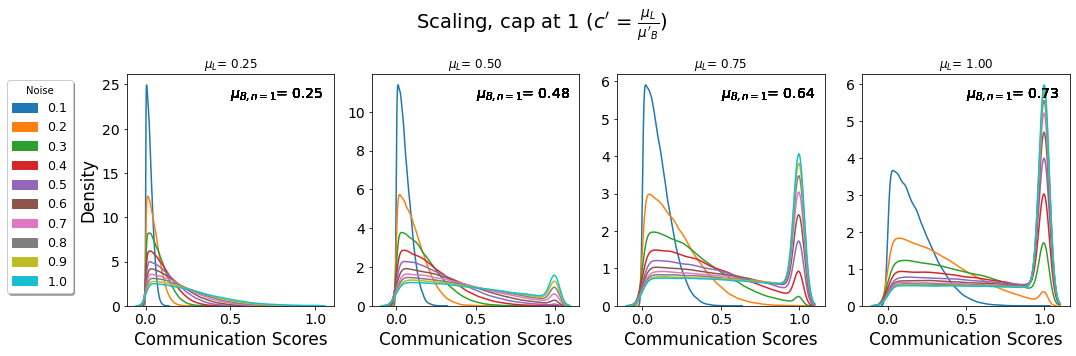

In [21]:
mean_vals = background_sim['mean'].unique().tolist()
noise_vals = background_sim['noise'].unique().tolist()
colors = sns.color_palette("tab10")[:len(noise_vals)]
fig, ax = plt.subplots(nrows = 1, ncols = len(mean_vals), figsize = (15,5))
for i in range(len(mean_vals)):
    for j in range(len(noise_vals)):
        viz_df = background_sim[(background_sim['mean'] == mean_vals[i]) & (background_sim['noise'] == noise_vals[j])]
        sns.distplot(a = viz_df['values'], color=colors[j], ax = ax[i], hist = False)
        ax[i].set_title(r'$\mu_L$' + '= {:.2f}'.format(mean_vals[i]))
        ax[i].annotate(r'$\mu_{B, n = 1}$' + '= {:.2f}'.format(summ.loc[i, 'mu_B']), 
              xycoords = 'axes fraction', xy = (0.5,0.9), fontsize = fontsize)    
        ax[i].set_xlabel('Communication Scores', fontsize = 1.2*fontsize)
        ax[i].tick_params(axis='both', labelsize=fontsize)
        if i > 0:
            ax[i].set_ylabel('')
        else:
            ax[i].set_ylabel('Density', fontsize = 1.2*fontsize)
    

patches = [mpatches.Patch(color=colors[j], label='{:.1f}'.format(noise_vals[j])) for j in range(len(noise_vals))]
ax[0].legend(handles=patches, title = 'Noise', bbox_to_anchor=(-0.23, 1), fontsize = 0.9*fontsize, 
            fancybox = True, shadow = True)
fig.suptitle("Scaling, cap at 1 ($\it{c'}$ = " + r"$\frac{\mu_L}{\mu'_B}$" + ')', fontsize = 1.4*fontsize)
plt.subplots_adjust(top = 0.8)
fig.align_xlabels(ax[:])
plt.tight_layout()

for ext in ['.pdf', '.png', '.svg']:
    plt.savefig(dp + 'background_noise_means_scale_cap' + ext, bbox_inches = 'tight')
;

# Non-Background

In [23]:
actual_interactions = pd.DataFrame(columns = ['values', 'mean', 'noise'])
for mean in np.arange(0.25, 1.01, 0.25):
    for noise in np.arange(0.1, 1.01, 0.1):
        vals = get_truncated_normal(n = 10**5, sd = noise*mean*1.1, mean = mean)
        df = pd.DataFrame(columns = ['values', 'mean', 'noise'])
        df['values'] = vals
        df['mean'] = mean
        df['noise'] = noise
        actual_interactions = pd.concat([actual_interactions, df])

''

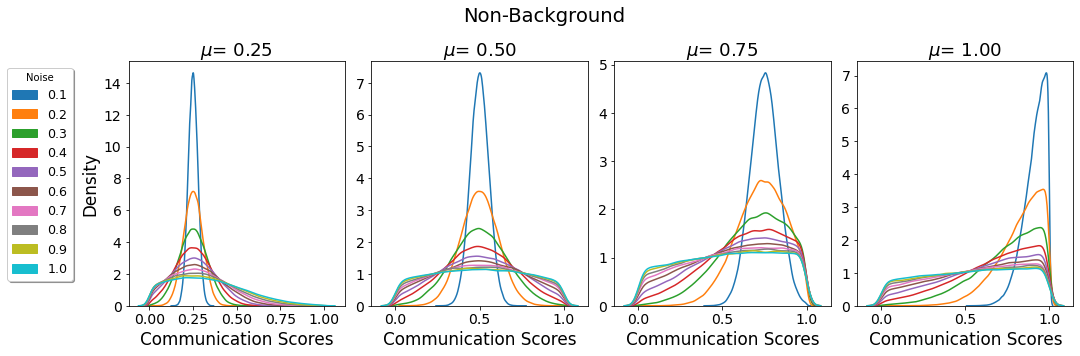

In [24]:
mean_vals = actual_interactions['mean'].unique().tolist()
noise_vals = actual_interactions['noise'].unique().tolist()
colors = sns.color_palette("tab10")[:len(noise_vals)]
fig, ax = plt.subplots(nrows = 1, ncols = len(mean_vals), figsize = (15,5))
for i in range(len(mean_vals)):
    for j in range(len(noise_vals)):
        viz_df = actual_interactions[(actual_interactions['mean'] == mean_vals[i]) & (actual_interactions['noise'] == noise_vals[j])]
        sns.distplot(a = viz_df['values'], color=colors[j], ax = ax[i], hist = False)
        ax[i].set_title(r'$\mu$' + '= {:.2f}'.format(mean_vals[i]), fontsize = 1.3*fontsize)
        ax[i].set_xlabel('Communication Scores', fontsize = 1.2*fontsize)
        ax[i].tick_params(axis='both', labelsize=fontsize)
        if i > 0:
            ax[i].set_ylabel('')
        else:
            ax[i].set_ylabel('Density', fontsize = 1.2*fontsize)
    

patches = [mpatches.Patch(color=colors[j], label='{:.1f}'.format(noise_vals[j])) for j in range(len(noise_vals))]
ax[0].legend(handles=patches, title = 'Noise', bbox_to_anchor=(-0.23, 1), fontsize = 0.9*fontsize, 
            fancybox = True, shadow = True)


fig.suptitle('Non-Background', fontsize = 1.4*fontsize)
plt.subplots_adjust(top = 0.8)
fig.align_xlabels(ax[:])
plt.tight_layout()
for ext in ['.pdf', '.png', '.svg']:
    plt.savefig(dp + 'actual_noise_means' + ext, bbox_inches = 'tight')
;

# What does a tensor slice look like across noise?

In [2]:
# # generate simulation object
# sim = Simulate() 
# sim.LR_network(network_type = 'scale-free', **{'nodes': 100, 'degrees': 3, 'alpha': 2}) #scale-free
# sim.LR.generate_metadata(n_LR_cats = {3: 0}, cat_skew = 0)

# cci = CCI_MD()
# cci.cci_network(n_cells = 15, directional = True, autocrine = True)
# cci.generate_metadata(n_cell_cats = {3: 0}, cat_skew = 0, remove_homotypic = 0)

# sim.cci = cci 
# sim.generate_tensor_md(n_patterns = 4, n_conditions = 0, patterns = ['pulse', 'linear', 'oscillate', 'power'], 
#                       consider_homotypic = True, score_change = 'max')

/home/hratch/Projects/c2c_sim/explore/tmpyjh9l314_bipartite_sf.csv
Generate undirected, bipartite, scale-free graph
Check network properties
All properties are as expected


In [3]:
# background_coords = sim.get_background()

In [4]:
# print('Generate melted df for one tensor slice')
# res_all = pd.DataFrame(columns = ['score', 'noise', 'cat'])
# for noise in tqdm(np.arange(0,1.01, 0.2)):
#     viz = sim.copy()
#     viz.generate_tensor(noise = noise, noise_max = None)
#     for cat in viz.clrm.index:
#         res_ = pd.DataFrame(columns = ['score', 'cat', 'noise'])
#         res_['score'] = viz.ts['0'].values[viz.clrm.loc[cat,'ts_coordinates']]
#         res_['cat'] = str(cat+1)
#         res_['noise'] = noise
#         res_all = pd.concat([res_all, res_], axis = 0)
    
#     res_ = pd.DataFrame(columns = ['score', 'cat', 'noise'])
#     res_['score'] = viz.ts['0'].values[background_coords]
#     res_['cat'] = 'background'
#     res_['noise'] = noise
#     res_all = pd.concat([res_all, res_], axis = 0)
    
# res_all.reset_index(inplace = True, drop = True)
# res_all['score'] = res_all['score'].astype(float)

# cats = sorted(res_all.cat.unique()) 
# cats.remove('background')
# list_ordering = ['background'] + cats
# res_all["cat"] = pd.Categorical(res_all["cat"], categories=list_ordering) 

  0%|          | 0/6 [00:00<?, ?it/s]

Generate melted df for one tensor slice


100%|██████████| 6/6 [00:00<00:00, 14.43it/s]


Graph one tensor slice
Complete graph one tensor slice


''

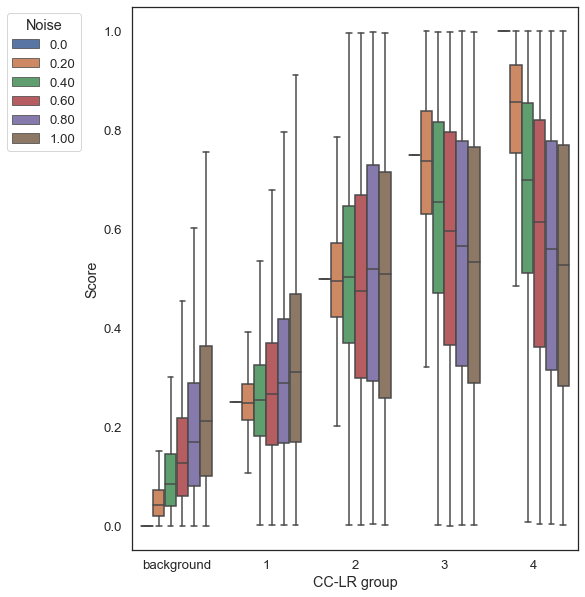

In [11]:
# print('Graph one tensor slice')
# sns.set(font_scale = 1.2, style = 'white')
# fig,ax = plt.subplots(figsize = (8,10))
# sns.boxplot(data = res_all, x = 'cat', y = 'score', hue = 'noise', 
#             showfliers=False)
# handles, labels = ax.get_legend_handles_labels()
# labels = [labels[0]] + ['{:.2f}'.format(float(i)) for i in labels[1:]]
# ax.legend(labels=labels, handles = handles,bbox_to_anchor=(-0.1, 1), title = 'Noise')
# ax.set_xlabel('CC-LR group')
# ax.set_ylabel('Score')
# plt.savefig(dp + 'ts0_comparison.pdf', bbox_to_inches = 'tight')
# plt.savefig(dp + 'ts0_comparison.png', bbox_to_inches = 'tight')
# print('Complete graph one tensor slice')
# ;

# What does a CC-LR metadata pair look like across conditions?

In [63]:
# generate random simulation object
sim = Simulate() 
sim.LR_network(network_type = 'scale-free', **{'nodes': 100, 'degrees': 3, 'alpha': 2}) #scale-free
sim.LR.generate_metadata(n_LR_cats = {3: 0}, cat_skew = 0)

cci = CCI_MD()
cci.cci_network(n_cells = 15, directional = True, autocrine = True)
cci.generate_metadata(n_cell_cats = {3: 0}, cat_skew = 0, remove_homotypic = 0)

sim.cci = cci 
sim.generate_tensor_md(n_patterns = 4, n_conditions = 10, patterns = ['pulse', 'linear', 'oscillate', 'power'], 
                      consider_homotypic = True, score_change = 'max')

# # generate simulation object with same pattern as main example
# with open(data_path + 'sim_obj_v' + str(version) + '.pickle', 'rb') as f:
#     sim_0 = pickle.load(f) # from sim_tensor_decompose_vis script
    
# sim = Simulate()
# sim.LR = copy.deepcopy(sim_0.LR)
# sim.cci = copy.deepcopy(sim_0.cci)
# sim.generate_tensor_md(n_patterns = 4, n_conditions = 12, patterns = ['pulse', 'linear', 'oscillate', 'power'], 
#                                      consider_homotypic = True, score_change = 'max')
# sim.clrm = copy.deepcopy(sim_0.clrm)
# sim.ts_frame = copy.deepcopy(sim_0.ts_frame)
# sim.n_conditions = copy.deepcopy(sim_0.n_conditions)

/home/hratch/Projects/c2c_sim/explore/tmpgt3y7v5o_bipartite_sf.csv
Generate undirected, bipartite, scale-free graph
Check network properties
All properties are as expected


In [64]:
background_coords = sim.get_background()

In [65]:
print('Generate melted df for multiple conditions')
res_all = pd.DataFrame(columns = ['score', 'noise', 'cat', 'condition'])

for noise in tqdm(np.arange(0,1.01, 0.33)):
    print('---------------------------------------')
    viz = sim.copy()
    viz.generate_tensor(noise = noise, noise_max = None, binary = False)
    for cond in viz.ts:
        for cat in viz.clrm.index:
            res_ = pd.DataFrame(columns = ['score', 'cat', 'noise', 'condition'])
            res_['score'] = viz.ts[cond].values[viz.clrm.loc[cat,'ts_coordinates']]
            res_['cat'] = str(cat+1)
            res_['noise'] = noise
            res_['condition'] = cond
            res_all = pd.concat([res_all, res_], axis = 0)

        res_ = pd.DataFrame(columns = ['score', 'cat', 'noise', 'condition'])
        res_['score'] = viz.ts['0'].values[background_coords]
        res_['cat'] = 'background'
        res_['noise'] = noise
        res_['condition'] = cond
        res_all = pd.concat([res_all, res_], axis = 0)
    
res_all.reset_index(inplace = True, drop = True)
res_all['score'] = res_all['score'].astype(float)

cats = sorted(res_all.cat.unique()) 
cats.remove('background')
cat_ordering = ['background'] + cats
res_all["cat"] = pd.Categorical(res_all["cat"], categories=cat_ordering) 

cond_ordering = sorted(res_all.condition.unique())
res_all["condition"] = pd.Categorical(res_all["condition"], categories=cond_ordering) 

noise_ordering = sorted(res_all.noise.unique())
res_all["noise"] = pd.Categorical(res_all["noise"], categories=noise_ordering) 

  0%|          | 0/4 [00:00<?, ?it/s]

Generate melted df for multiple conditions
---------------------------------------


 25%|██▌       | 1/4 [00:05<00:16,  5.44s/it]

---------------------------------------


 50%|█████     | 2/4 [00:14<00:15,  7.58s/it]

---------------------------------------


 75%|███████▌  | 3/4 [00:25<00:08,  8.94s/it]

---------------------------------------


100%|██████████| 4/4 [00:43<00:00, 10.76s/it]


''

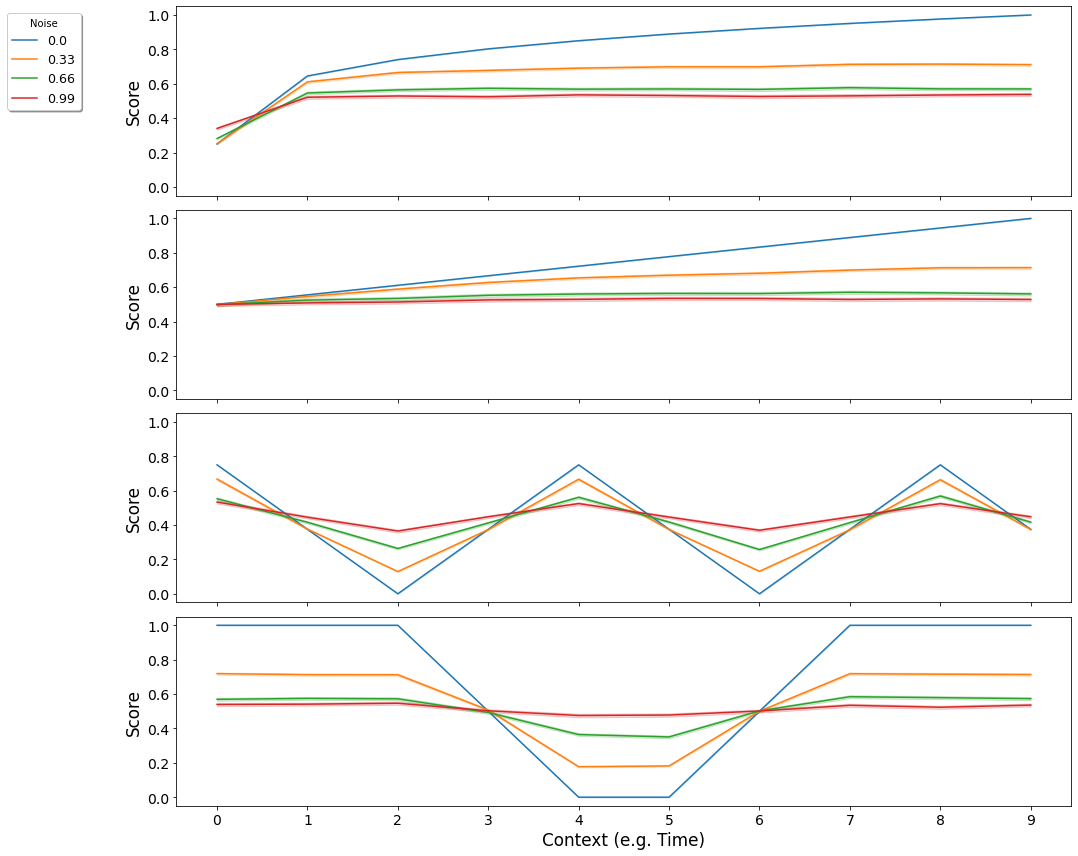

In [68]:
cats = sorted(res_all.cat.unique().tolist())
cats.remove('background')
# labels_ = ['{:.2f}'.format(n) for n in sorted(res_all.noise.unique())]
colors = sns.color_palette("tab10")[:len(res_all.noise.unique())]

fig, ax = plt.subplots(nrows = len(cats), figsize = (15,12), sharex = True, sharey = True)
counter = 0
for cat in cats:
    viz = res_all[res_all.cat == cat]
    sns.lineplot(data = viz, y = 'score', x = 'condition', hue =  'noise', palette = colors,
                 ax = ax[counter])
    ax[counter].set_ylabel('Score', fontsize = 1.2*fontsize)
    
    if counter == (len(cats)-1):
        ax[counter].set_xlabel('Context (e.g. Time)', fontsize = 1.2*fontsize)
    else:
        ax[counter].set_xlabel('')
    if counter == 0:
        handles, labels = ax[counter].get_legend_handles_labels()
        labels = [labels[0]] + ['{:.2f}'.format(float(i)) for i in labels[1:]]
        ax[counter].legend(labels=labels, handles = handles,bbox_to_anchor=(-0.1, 1), title = 'Noise', 
                          fancybox = True, shadow = True, fontsize = 0.9*fontsize)
    else:
        ax[counter].get_legend().remove()
    
    ax[counter].set_title('', fontsize = 1.3*fontsize)
    ax[counter].tick_params(axis='both', labelsize=fontsize)
    counter += 1
    
plt.subplots_adjust(hspace = 0.2)    
fig.align_xlabels(ax[:])
fig.align_ylabels(ax[:])


plt.tight_layout()
for ext in ['.pdf', '.png', '.svg']:
    plt.savefig(dp + 'pattern_delta_condition_noise' + ext, bbox_inches = 'tight')
;